**Install and load necessary modules/libraries**

In [62]:
# load necessary modules

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import missingno as msno
import mlflow

from sklearn import metrics
from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [318]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('penguin_logistic_regression_v3')

<Experiment: artifact_location='./mlruns/4', experiment_id='4', lifecycle_stage='active', name='penguin_logistic_regression_v3', tags={}>

**Data preprocessing**

In [319]:
# load csv file

df = pd.read_csv('../data/penguins.csv')

df.head()

,Unnamed: 0,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


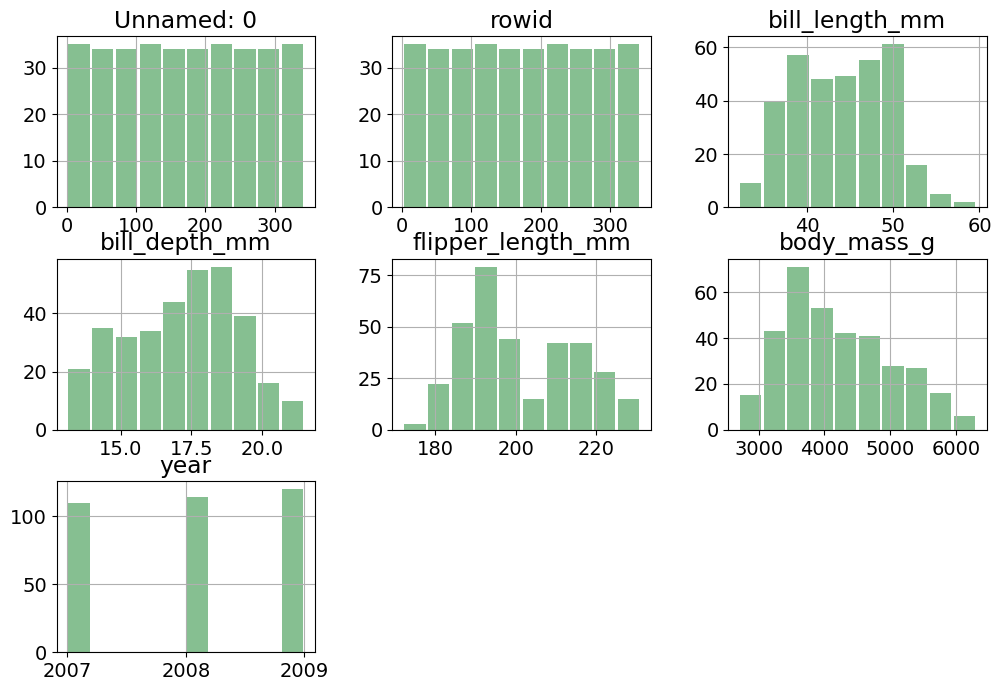

In [320]:
# check histograms

df.hist(bins=10, grid=True, figsize=(12,8), color='#86bf91', zorder=1, rwidth=0.9);

In [321]:
# drop duplicated if exist

df=df.drop_duplicates()

In [322]:
# check null values

df.isnull().sum()

Unnamed: 0            0
rowid                 0
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

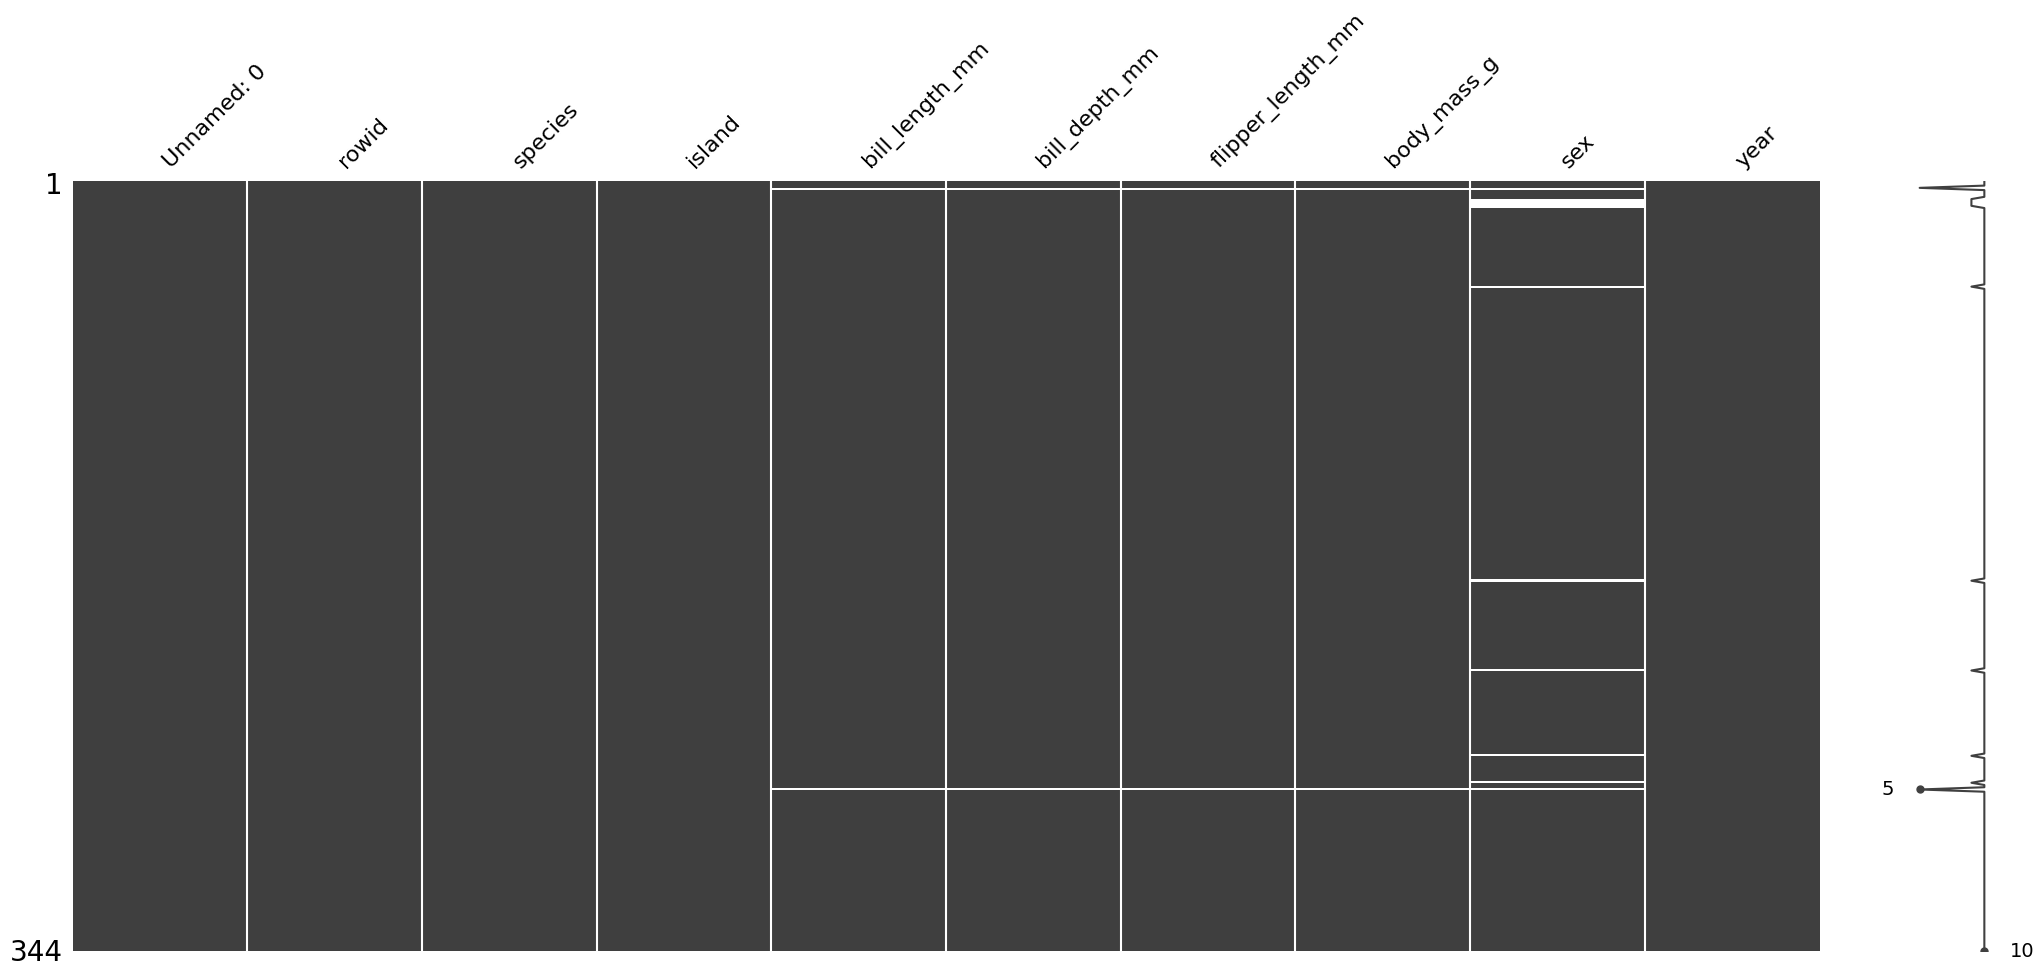

In [323]:
# check missing values

msno.matrix(df);

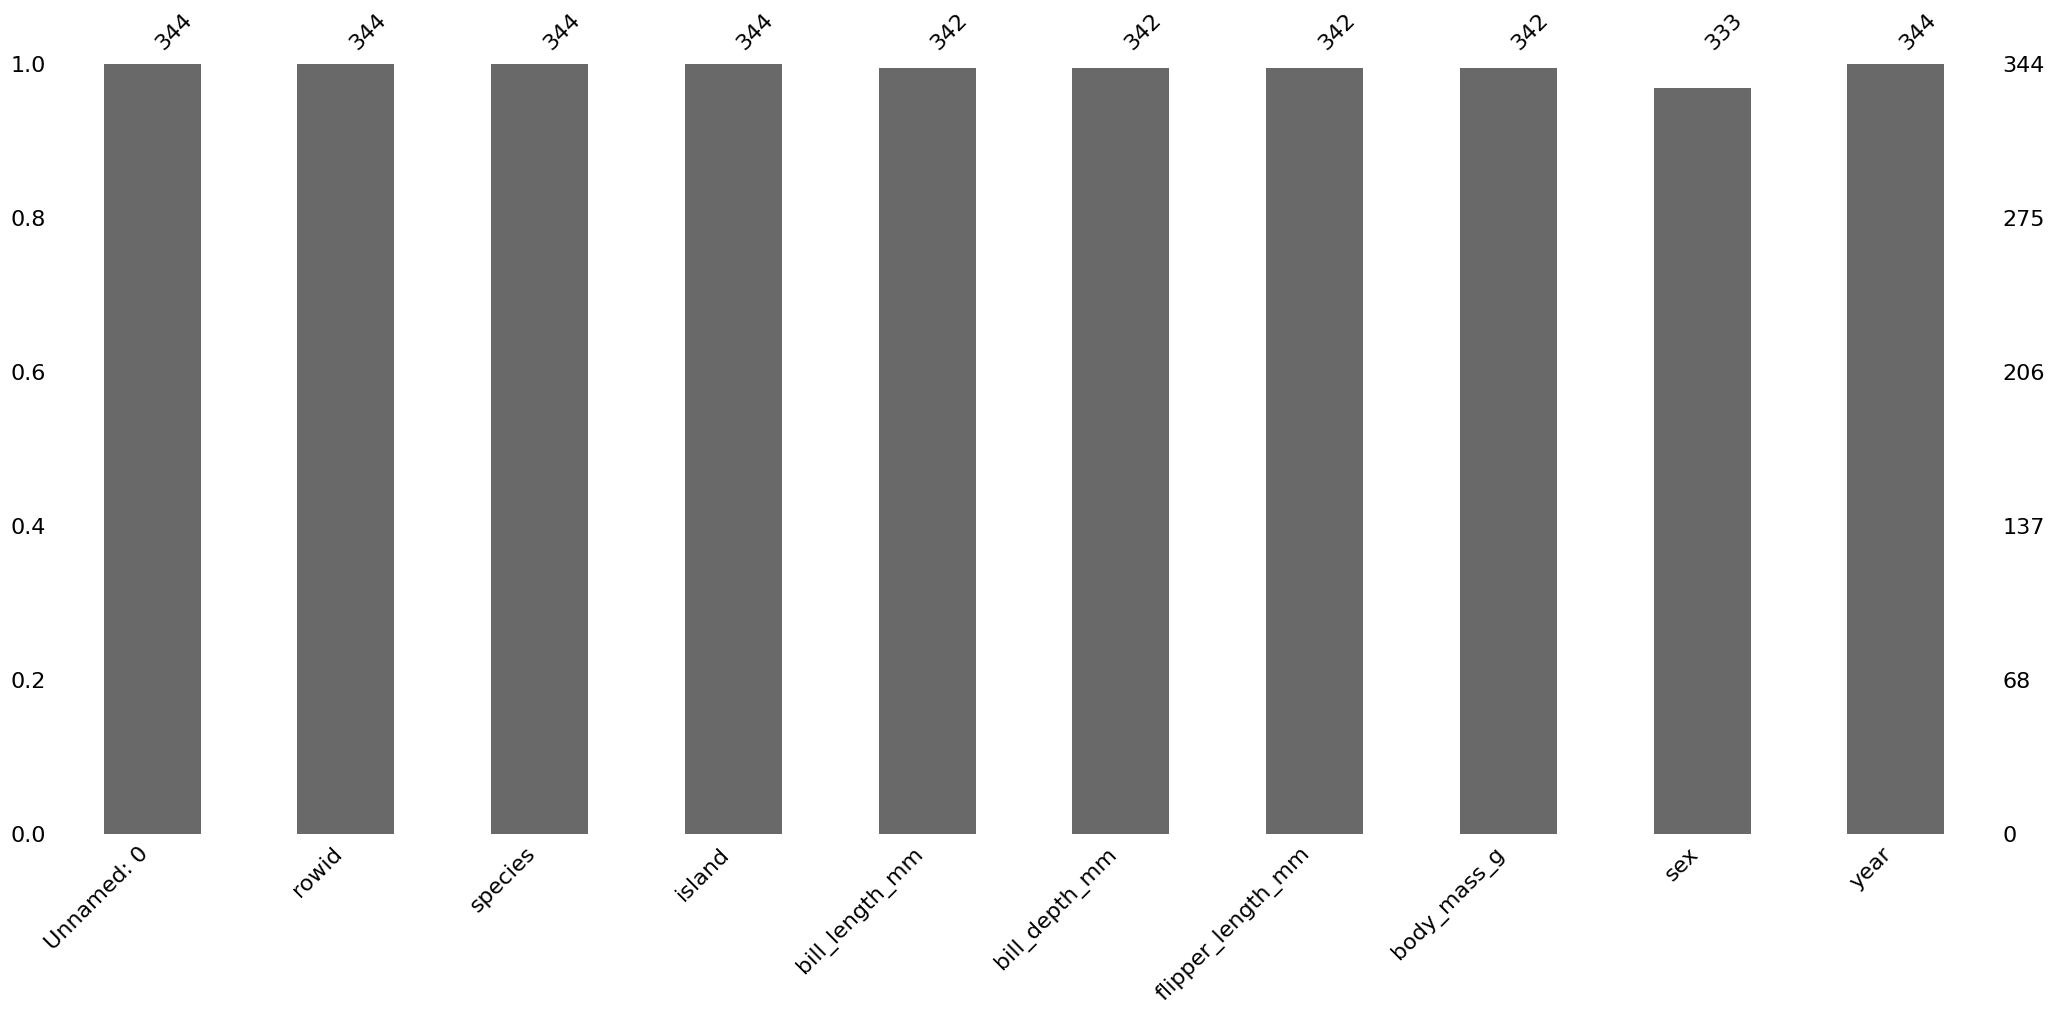

In [324]:
# visualize using bar plot of missing values

msno.bar(df);

In [325]:
# drop columns with missing values

df.dropna(axis=0,inplace=True)

df.shape

(333, 10)

In [326]:
# check df

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         333 non-null    int64  
 1   rowid              333 non-null    int64  
 2   species            333 non-null    object 
 3   island             333 non-null    object 
 4   bill_length_mm     333 non-null    float64
 5   bill_depth_mm      333 non-null    float64
 6   flipper_length_mm  333 non-null    float64
 7   body_mass_g        333 non-null    float64
 8   sex                333 non-null    object 
 9   year               333 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 28.6+ KB


In [327]:
# check types

df.dtypes

Unnamed: 0             int64
rowid                  int64
species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
year                   int64
dtype: object

In [328]:
# one hot encoding - nominal data

encoder=ce.OneHotEncoder(cols=['species','island'],handle_unknown='return_nan', return_df=True,use_cat_names=True)

df_enc=encoder.fit_transform(df)

df_enc

,Unnamed: 0,rowid,species_Adelie,species_Gentoo,species_Chinstrap,island_Torgersen,island_Biscoe,island_Dream,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,39.1,18.7,181.0,3750.0,male,2007
1,1,2,1.0,0.0,0.0,1.0,0.0,0.0,39.5,17.4,186.0,3800.0,female,2007
2,2,3,1.0,0.0,0.0,1.0,0.0,0.0,40.3,18.0,195.0,3250.0,female,2007
4,4,5,1.0,0.0,0.0,1.0,0.0,0.0,36.7,19.3,193.0,3450.0,female,2007
5,5,6,1.0,0.0,0.0,1.0,0.0,0.0,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,339,340,0.0,0.0,1.0,0.0,0.0,1.0,55.8,19.8,207.0,4000.0,male,2009
340,340,341,0.0,0.0,1.0,0.0,0.0,1.0,43.5,18.1,202.0,3400.0,female,2009
341,341,342,0.0,0.0,1.0,0.0,0.0,1.0,49.6,18.2,193.0,3775.0,male,2009
342,342,343,0.0,0.0,1.0,0.0,0.0,1.0,50.8,19.0,210.0,4100.0,male,2009


In [329]:
# add a new column with labels

df_enc.loc[df_enc.sex == 'male', 'label'] = int(1)
df_enc.loc[df_enc.sex == 'female', 'label'] = int(0)
df_enc['label'].astype('float')
df_enc.head()

,Unnamed: 0,rowid,species_Adelie,species_Gentoo,species_Chinstrap,island_Torgersen,island_Biscoe,island_Dream,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,label
0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,39.1,18.7,181.0,3750.0,male,2007,1.0
1,1,2,1.0,0.0,0.0,1.0,0.0,0.0,39.5,17.4,186.0,3800.0,female,2007,0.0
2,2,3,1.0,0.0,0.0,1.0,0.0,0.0,40.3,18.0,195.0,3250.0,female,2007,0.0
4,4,5,1.0,0.0,0.0,1.0,0.0,0.0,36.7,19.3,193.0,3450.0,female,2007,0.0
5,5,6,1.0,0.0,0.0,1.0,0.0,0.0,39.3,20.6,190.0,3650.0,male,2007,1.0


In [330]:
# check number of males/females to inspect if dataset is imbalanced

df_enc['label'].value_counts()

1.0    168
0.0    165
Name: label, dtype: int64

In [331]:
# get labels

labels = df_enc[['label']]
y = labels.to_numpy().reshape(-1,)

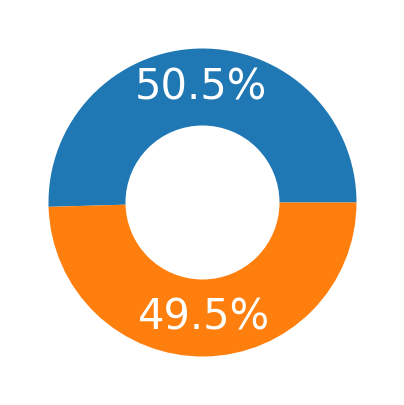

In [332]:
# pie chart

vc=labels.value_counts()

plt.figure(figsize=(5,5))

patches, texts, autotexts=plt.pie(vc,labels=None,shadow=False,autopct='%1.1f%%',pctdistance=0.75) # startangle=90)
centre_circle = plt.Circle((0,0),0.50,fc='white')
plt.gcf()
plt.gca().add_artist(centre_circle)
for text in texts:
    text.set_size(26)
for text in autotexts:
    text.set_size(30)
for ctext in autotexts:
    ctext.set_color('white')
plt.show()

In [333]:
# drop useless columns

df_enc.drop(columns=['rowid','sex'],axis=1,inplace=True)

In [334]:
# get features

X = df_enc.iloc[:,:11].values



**ML: Logistic regression**

In [335]:
# split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [336]:
# build a model

mlflow.sklearn.autolog()

with mlflow.start_run():
    
    #mlflow.set_tag("author", "Mikhail")
    #mlflow.set_tag("logistic-regression","model")
    mlflow.log_param("data", "../data/penguins.csv")
    
    #regularization = 0.01
    #mlflow.log_param("regulatization", regularization)

    # standartization, fitting and estimation of the errors
    scaler = StandardScaler()
    log_reg = LogisticRegression(C=regularization, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False)
    pipe_def_model = Pipeline([('scaler', scaler), ('log_reg', log_reg)])
    pipe_def_model.fit(X_train, y_train)
    err_train_def_model = pipe_def_model.score(X_train, y_train)
    err_val_def_model = pipe_def_model.score(X_val, y_val)
    y_pred_def_model = pipe_def_model.predict(X)
    accuracy_def_model = pipe_def_model.score(X, y)

    #mlflow.log_metric("training-error", err_train_def_model)
    #mlflow.log_metric("validation-error", err_val_def_model)
    #mlflow.log_metric("accuracy", accuracy_def_model)
    
    # printing
    print(f"Accuracy of classification: {round(100*accuracy_def_model, 2)}%")
    print(f"Training error: {err_train_def_model}")
    print(f"Validation error: {err_val_def_model}")
    
    #model_name = "model_lr.bin"
    #with open("/models/" + model_name, 'wb') as fout:
    #    pickle.dump((cv, log_reg), fout)
        
    #mlflow.log_artifact(local_path="/models" + model_name, artifact_path="/")

Accuracy of classification: 90.69%
Training error: 0.9135338345864662
Validation error: 0.8805970149253731


/Users/mikhailkuklin/miniforge3/envs/mlflow_tacking-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


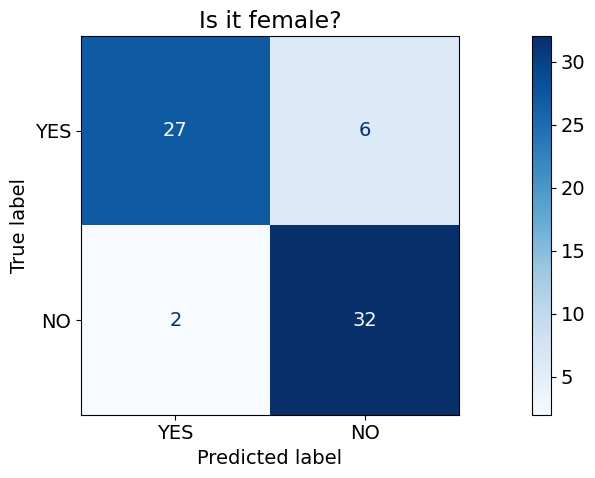

In [337]:
from sklearn.metrics import plot_confusion_matrix

# Define class labels for confusion matrices
classes = ['YES','NO']

# Define plotting options (title, normalization, axes index)
options = [("Is it female?", None, 0)]

# Plot confusion matrices
fig, axes = plt.subplots(1, 1, figsize=(15, 5))  # Create subplots (1 row, 2 columns)
plt.rc('font', size=14)  # Set fontsize
for title, normalize, ax_idx in options:
    # main parameters of function `plot_confusion_matrix` are:
    # trained classifier (log_reg), data (X, y)
    disp = plot_confusion_matrix(pipe_def_model, X_val, y_val,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 values_format='.0f', 
                                 normalize=None, ax=axes)
    disp.ax_.set_title(title)
fig.tight_layout()
plt.show()

/Users/mikhailkuklin/miniforge3/envs/mlflow_tacking-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


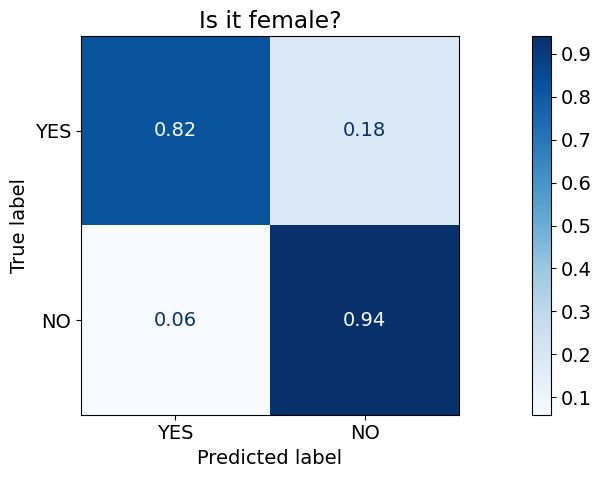

In [338]:
# Define class labels for confusion matrices
classes = ['YES','NO']

# Define plotting options (title, normalization, axes index)
options = [("Is it female?", 'true', 1)]

# Plot confusion matrices
fig, axes = plt.subplots(1, 1, figsize=(15, 5))  # Create subplots (1 row, 2 columns)
plt.rc('font', size=14)  # Set fontsize
for title, normalize, ax_idx in options:
    # main parameters of function `plot_confusion_matrix` are:
    # trained classifier (log_reg), data (X, y)
    disp = plot_confusion_matrix(pipe_def_model, X_val, y_val,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 values_format='.2f', 
                                 normalize=normalize, ax=axes)
    disp.ax_.set_title(title)
fig.tight_layout()
plt.show()

In [339]:
# table view

predicted_def_model = pipe_def_model.predict(X_val)
cm_def_model=confusion_matrix(y_val, predicted_def_model)
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_val,predicted_def_model,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

matrix = classification_report(y_val,predicted_def_model,labels=[0,1])
print('Classification report : \n',matrix)

Outcome values : 
 27 6 2 32
Classification report : 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.84      0.94      0.89        34

    accuracy                           0.88        67
   macro avg       0.89      0.88      0.88        67
weighted avg       0.89      0.88      0.88        67



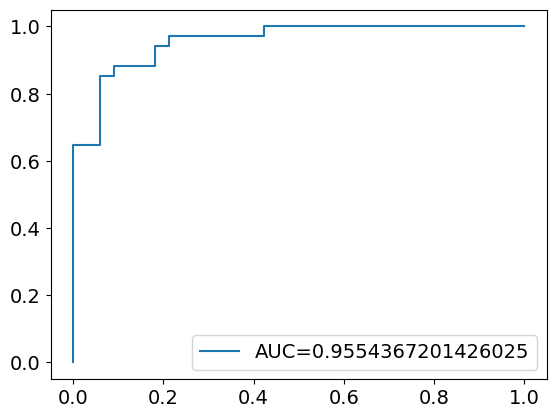

In [340]:
# ROC

y_pred_proba = pipe_def_model.predict_proba(X_val)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()